# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [51]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/sofieschnitzer/Desktop/KTH_HT25_filer/ID2223/mlfs-book_YairRT
HopsworksSettings initialized!


In [52]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [53]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 13, 7, 44, 215368)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [54]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 13:07:44,288 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 13:07:44,317 INFO: Initializing external client
2025-11-16 13:07:44,319 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 13:07:44,911 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 13:07:45,734 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1293460


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [55]:
mr = project.get_model_registry()

# Updated to version 2 - includes lag features (Grade C)
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=2,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 13:07:50,562 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/526230 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119573 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28002 elapsed<00:00 remaining<?

In [56]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.225929E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [57]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,8.00,0.0,27.778379,273.715210,San Francisco
1,2025-11-17 00:00:00+00:00,7.50,0.0,11.570515,354.644257,San Francisco
2,2025-11-19 00:00:00+00:00,4.40,0.0,24.850431,321.469788,San Francisco
3,2025-11-22 00:00:00+00:00,7.75,0.0,16.595179,245.658920,San Francisco
4,2025-11-20 00:00:00+00:00,5.75,0.0,18.043148,331.389618,San Francisco
5,2025-11-21 00:00:00+00:00,5.80,0.0,18.171976,213.690094,San Francisco


In [58]:
# Get recent PM2.5 history to compute lag features for predictions (Grade C requirement)
air_quality_fg_v2 = fs.get_feature_group(name='air_quality', version=2)
recent_pm25 = (
    air_quality_fg_v2.read()
    .query("street == @street")
    .sort_values('date')
    .tail(3)
    [['date', 'pm25']]
)

# Normalize dates to avoid timezone issues
recent_pm25['date'] = pd.to_datetime(recent_pm25['date']).dt.tz_localize(None)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.tz_localize(None)

# Get the most recent PM2.5 values for lag features
# For future dates, we use the most recent historical values
if len(recent_pm25) > 0:
    last_pm25 = recent_pm25['pm25'].iloc[-1] if len(recent_pm25) >= 1 else None
    second_last_pm25 = recent_pm25['pm25'].iloc[-2] if len(recent_pm25) >= 2 else last_pm25
    third_last_pm25 = recent_pm25['pm25'].iloc[-3] if len(recent_pm25) >= 3 else second_last_pm25
    
    # Add lag features to batch_data (using most recent values for all future dates)
    batch_data['pm25_lag_1'] = last_pm25
    batch_data['pm25_lag_2'] = second_last_pm25
    batch_data['pm25_lag_3'] = third_last_pm25
    
    # Compute rolling mean
    if len(recent_pm25) >= 3:
        batch_data['pm25_roll_3'] = recent_pm25['pm25'].tail(3).mean()
    elif len(recent_pm25) >= 2:
        batch_data['pm25_roll_3'] = recent_pm25['pm25'].tail(2).mean()
    else:
        batch_data['pm25_roll_3'] = last_pm25
else:
    # Fallback if no history available
    batch_data['pm25_lag_1'] = None
    batch_data['pm25_lag_2'] = None
    batch_data['pm25_lag_3'] = None
    batch_data['pm25_roll_3'] = None

print("Lag features added to batch_data:")
print(batch_data[['date', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3']].head())


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 
Lag features added to batch_data:
        date  pm25_lag_1  pm25_lag_2  pm25_lag_3  pm25_roll_3
0 2025-11-18        25.0        38.0        34.0    32.333332
1 2025-11-17        25.0        38.0        34.0    32.333332
2 2025-11-19        25.0        38.0        34.0    32.333332
3 2025-11-22        25.0        38.0        34.0    32.333332
4 2025-11-20        25.0        38.0        34.0    32.333332


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [59]:
# Include lag features in prediction (model expects features in specific order - Grade C)
# Model expects: lag features first, then weather features
feature_cols = [
    'pm25_lag_1',
    'pm25_lag_2', 
    'pm25_lag_3',
    'pm25_roll_3',
    'temperature_2m_mean', 
    'precipitation_sum', 
    'wind_speed_10m_max', 
    'wind_direction_10m_dominant'
]

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_cols])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25
0,2025-11-18,8.00,0.0,27.778379,273.715210,San Francisco,25.0,38.0,34.0,32.333332,27.867369
1,2025-11-17,7.50,0.0,11.570515,354.644257,San Francisco,25.0,38.0,34.0,32.333332,25.004976
2,2025-11-19,4.40,0.0,24.850431,321.469788,San Francisco,25.0,38.0,34.0,32.333332,27.434044
3,2025-11-22,7.75,0.0,16.595179,245.658920,San Francisco,25.0,38.0,34.0,32.333332,28.089066
4,2025-11-20,5.75,0.0,18.043148,331.389618,San Francisco,25.0,38.0,34.0,32.333332,27.871000
5,2025-11-21,5.80,0.0,18.171976,213.690094,San Francisco,25.0,38.0,34.0,32.333332,30.209444


In [60]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         6 non-null      datetime64[us]
 1   temperature_2m_mean          6 non-null      float32       
 2   precipitation_sum            6 non-null      float32       
 3   wind_speed_10m_max           6 non-null      float32       
 4   wind_direction_10m_dominant  6 non-null      float32       
 5   city                         6 non-null      object        
 6   pm25_lag_1                   6 non-null      float32       
 7   pm25_lag_2                   6 non-null      float32       
 8   pm25_lag_3                   6 non-null      float32       
 9   pm25_roll_3                  6 non-null      float32       
 10  predicted_pm25               6 non-null      float32       
dtypes: datetime64[us](1), float32(9), object(1)
memor

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [61]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-17,7.50,0.0,11.570515,354.644257,San Francisco,25.0,38.0,34.0,32.333332,25.004976,San Francisco-Arkansas Street,California,2
0,2025-11-18,8.00,0.0,27.778379,273.715210,San Francisco,25.0,38.0,34.0,32.333332,27.867369,San Francisco-Arkansas Street,California,1
2,2025-11-19,4.40,0.0,24.850431,321.469788,San Francisco,25.0,38.0,34.0,32.333332,27.434044,San Francisco-Arkansas Street,California,3
4,2025-11-20,5.75,0.0,18.043148,331.389618,San Francisco,25.0,38.0,34.0,32.333332,27.871000,San Francisco-Arkansas Street,California,5
5,2025-11-21,5.80,0.0,18.171976,213.690094,San Francisco,25.0,38.0,34.0,32.333332,30.209444,San Francisco-Arkansas Street,California,6
3,2025-11-22,7.75,0.0,16.595179,245.658920,San Francisco,25.0,38.0,34.0,32.333332,28.089066,San Francisco-Arkansas Street,California,4


In [62]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 3
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         6 non-null      datetime64[us]
 1   temperature_2m_mean          6 non-null      float32       
 2   precipitation_sum            6 non-null      float32       
 3   wind_speed_10m_max           6 non-null      float32       
 4   wind_direction_10m_dominant  6 non-null      float32       
 5   city                         6 non-null      object        
 6   pm25_lag_1                   6 non-null      float32       
 7   pm25_lag_2                   6 non-null      float32       
 8   pm25_lag_3                   6 non-null      float32       
 9   pm25_roll_3                  6 non-null      float32       
 10  predicted_pm25               6 non-null      float32       
 11  street                       6 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

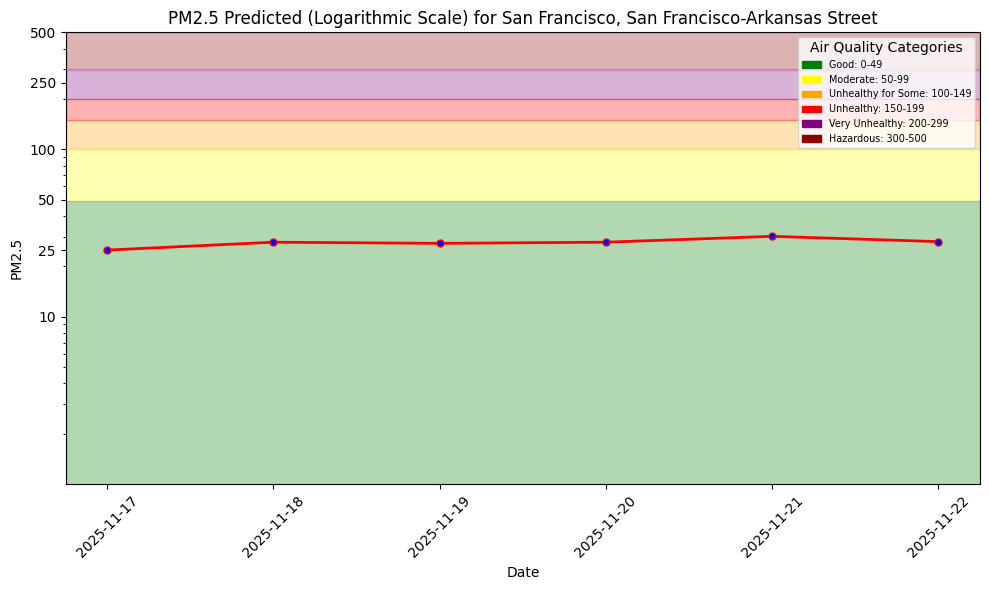

In [63]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [64]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [65]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1293460/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 13:08:17,240 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:08:20,441 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:09:55,925 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:09:56,091 INFO: Waiting for log aggregation to finish.
2025-11-16 13:10:08,118 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [66]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,8.0,0.0,27.778379,273.71521,San Francisco,25.0,38.0,34.0,32.333332,27.867369,San Francisco-Arkansas Street,California,1


In [67]:
# Updated to version 2 - includes lag features (Grade C)
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3
0,2014-11-26 00:00:00+00:00,64.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,57.0,36.0,21.0,38.000000
1,2020-08-31 00:00:00+00:00,82.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,54.0,51.0,83.0,62.666667
2,2020-02-24 00:00:00+00:00,36.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,28.0,51.0,49.0,42.666667
3,2021-03-06 00:00:00+00:00,12.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,30.0,34.0,39.0,34.333333
4,2021-03-12 00:00:00+00:00,26.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,14.0,12.0,16.0,14.000000
...,...,...,...,...,...,...,...,...,...,...
4168,2024-05-28 00:00:00+00:00,32.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,19.0,28.0,26.0,24.333333
4169,2023-06-20 00:00:00+00:00,22.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,20.0,26.0,23.0,23.000000
4170,2018-04-13 00:00:00+00:00,33.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,31.0,23.0,33.0,29.000000
4171,2025-11-12 00:00:00+00:00,38.0,California,San Francisco,San Francisco-Arkansas Street,https://api.waqi.info/feed/@3900,34.0,17.0,22.0,24.333333


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# Note: Hindcast will be empty initially - this is normal!
# The backfill function is commented out because it needs to be updated to support lag features
# After a few days of predictions and actual observations, you'll get data points in the hindcast graph
# if len(hindcast_df) == 0:
#     hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

print(f"Hindcast data points: {len(hindcast_df)}")
if len(hindcast_df) == 0:
    print("(This is expected - hindcast will populate after predictions and actual observations are available)")
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


ValueError: feature_names mismatch: ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected pm25_lag_3, pm25_roll_3, pm25_lag_2, pm25_lag_1 in input data

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

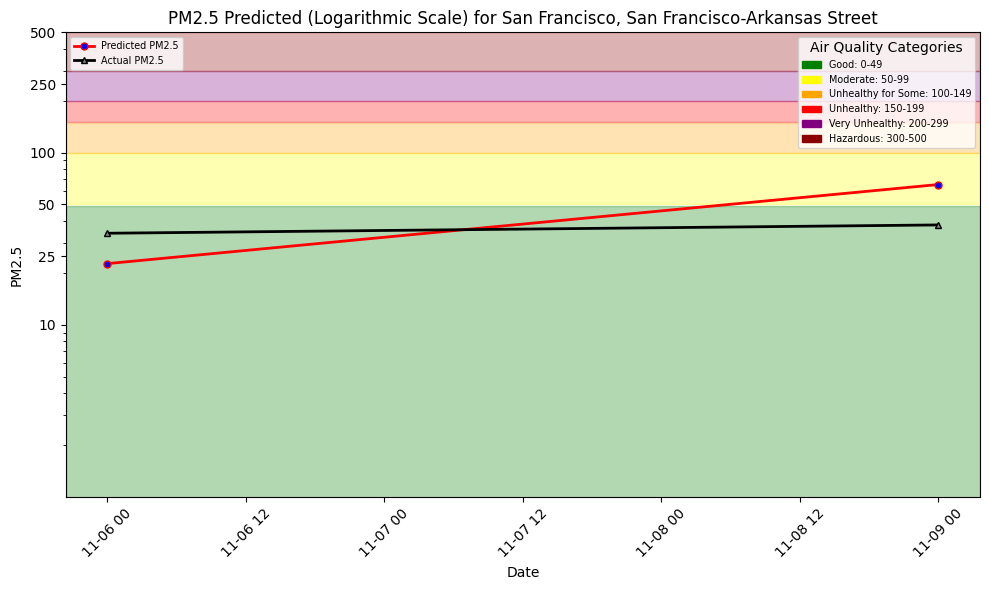

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/yairrios/Documents/KTH/Second Year/Scalable_ML/mlfs-book_YairRT_SofieSchn/docs/air-quality/as…

Uploading /Users/yairrios/Documents/KTH/Second Year/Scalable_ML/mlfs-book_YairRT_SofieSchn/docs/air-quality/as…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272002/settings/fb/path/Resources/airquality


---